In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Pattern/healthcare-dataset-stroke-data.csv')
print(data.shape)
data.head(3)


(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1


In [4]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.00,5110.00,5110.00,4909.00,5110.00
mean,36517.83,43.23,0.10,0.05,106.15,28.89,0.05
std,21161.72,22.61,0.30,0.23,45.28,7.85,0.22
min,67.00,0.08,0.00,0.00,55.12,10.30,0.00
25%,17741.25,25.00,0.00,0.00,77.25,23.50,0.00
50%,36932.00,45.00,0.00,0.00,91.88,28.10,0.00
75%,54682.00,61.00,0.00,0.00,114.09,33.10,0.00
max,72940.00,82.00,1.00,1.00,271.74,97.60,1.00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


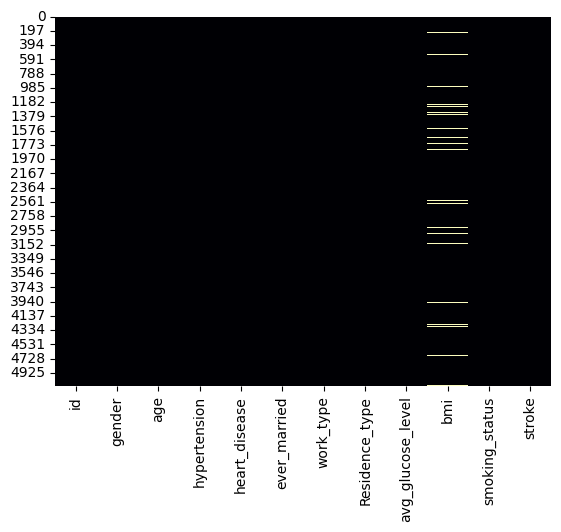

In [6]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

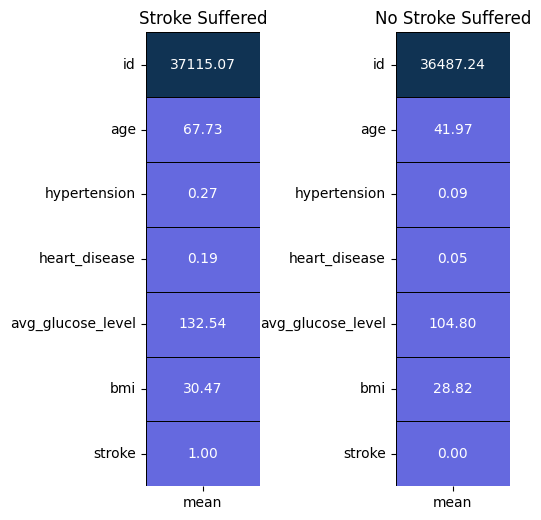

In [7]:
stroke = data[data['stroke'] == 1].describe().T
no_stroke = data[data['stroke'] == 0].describe().T

colors = ['#6569df','#103353']

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(stroke[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Stroke Suffered');

plt.subplot(1,2,2)
sns.heatmap(no_stroke[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('No Stroke Suffered');

fig.tight_layout(pad = 0)

In [8]:
l1 = [i for i in tqdm(range(len(data.isnull()['bmi']))) if data.isnull().loc[i,'bmi'] == True]
print('Total Number of Missing Values in bmi feature :', len(l1))

100%|██████████| 5110/5110 [00:32<00:00, 154.88it/s]

Total Number of Missing Values in bmi feature : 201


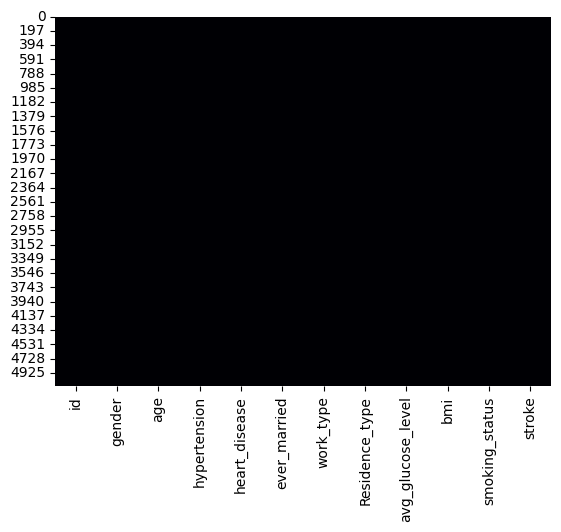

In [9]:
data['bmi'].fillna(data['bmi'].mean(),inplace = True)
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

**Numerical and Categorical features:**

In [10]:
data.drop(columns = ['id'],inplace = True)
col = list(data.columns)
categorical_features = []
discrete_features = []
for i in col:
    if len(data[i].unique()) > 6:
        discrete_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Discrete Features :',*discrete_features)

data['age'] = data['age'].astype(int)
df1 = data.copy(deep = True)

Categorical Features : gender hypertension heart_disease ever_married work_type Residence_type smoking_status stroke
Discrete Features : age avg_glucose_level bmi


In [11]:
le = LabelEncoder()
text_data_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in tqdm(text_data_features):
    df1[i] = le.fit_transform(df1[i])
    l3.append(list(df1[i].unique())); l4.append(list(le.inverse_transform(df1[i].unique())))
    print(i,' : ',df1[i].unique(),' = ',le.inverse_transform(df1[i].unique()))

Label Encoder Transformation


100%|██████████| 5/5 [00:00<00:00, 102.68it/s]

gender  :  [1 0 2]  =  ['Male' 'Female' 'Other']
ever_married  :  [1 0]  =  ['Yes' 'No']
work_type  :  [2 3 0 4 1]  =  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type  :  [1 0]  =  ['Urban' 'Rural']
smoking_status  :  [1 2 3 0]  =  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [12]:
tf1 = {}
for i in range(len(text_data_features)):
    tf1[text_data_features[i]] = {}
    for j,k in zip(l3[i],l4[i]):
        tf1[text_data_features[i]][j] = k

tf1['hypertension'] = {0 : 'No Hypertension', 1 : 'Hypertension'}
tf1['heart_disease'] = {0 : 'No Heart Disease', 1 : 'Heart Disease'}
tf1

{'gender': {1: 'Male', 0: 'Female', 2: 'Other'},
 'ever_married': {1: 'Yes', 0: 'No'},
 'work_type': {2: 'Private',
  3: 'Self-employed',
  0: 'Govt_job',
  4: 'children',
  1: 'Never_worked'},
 'Residence_type': {1: 'Urban', 0: 'Rural'},
 'smoking_status': {1: 'formerly smoked',
  2: 'never smoked',
  3: 'smokes',
  0: 'Unknown'},
 'hypertension': {0: 'No Hypertension', 1: 'Hypertension'},
 'heart_disease': {0: 'No Heart Disease', 1: 'Heart Disease'}}

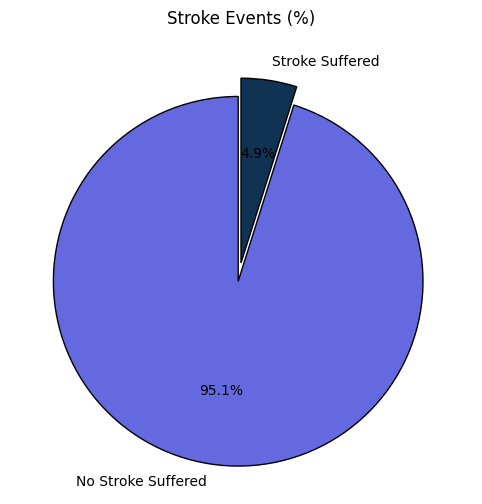

In [13]:
import matplotlib.pyplot as plt

l = list(df1['stroke'].value_counts())
circle = [l[0] / sum(l) * 100, l[1] / sum(l) * 100]

colors = ['#6569df','#103353']
plt.figure(figsize=(8, 6))
plt.pie(circle, labels=['No Stroke Suffered', 'Stroke Suffered'], autopct='%1.1f%%', startangle=90, explode=(0.1, 0), colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
plt.title('Stroke Events (%)')
plt.show()

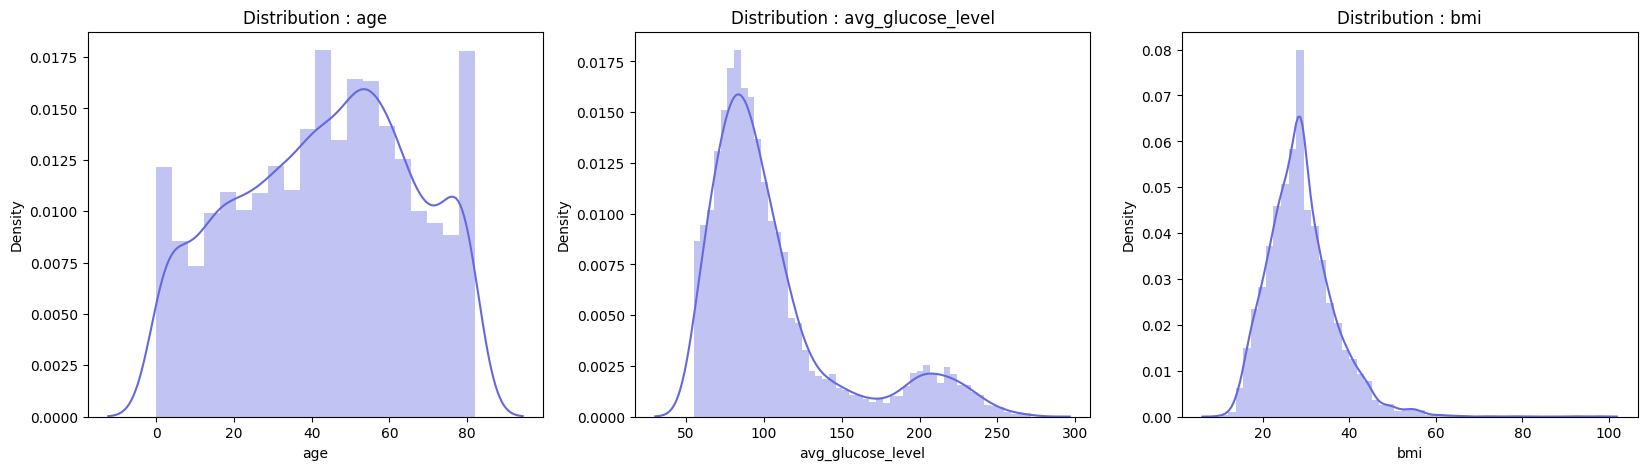

In [14]:
fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (20,5))
for i in range(len(discrete_features)):
    plt.subplot(1,3,i+1)
    sns.distplot(df1[discrete_features[i]],color = colors[0])
    title = 'Distribution : ' + discrete_features[i]
    plt.title(title)
plt.show()

In [22]:
categorical_features.remove('stroke')

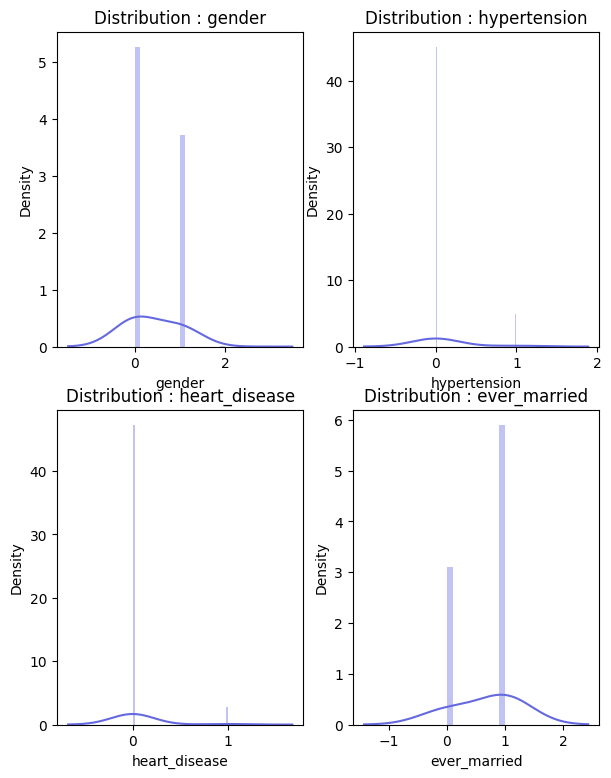

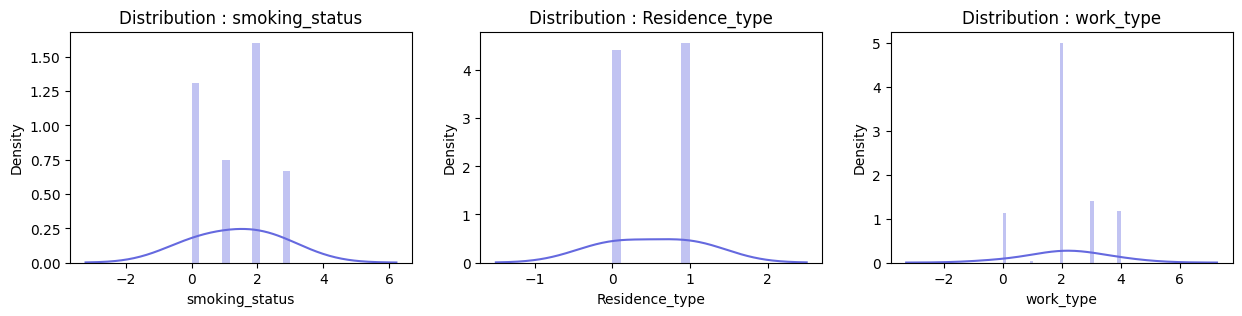

In [23]:
fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize = (7,9))
for i in range(len(categorical_features[:4])):
    plt.subplot(2,2,i+1)
    sns.distplot(df1[categorical_features[i]],kde_kws = {'bw' : 1},color = colors[0]);
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)

fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,3))
for i in range(-1,-4,-1):
    plt.subplot(1,3,-i)
    sns.distplot(df1[categorical_features[i]],kde_kws = {'bw' : 1},color = colors[0]);
    title = 'Distribution : ' + categorical_features[i]
    plt.title(title)

In [24]:
over = SMOTE(sampling_strategy = 1)
under = RandomUnderSampler(sampling_strategy = 0.1)
f1 = df1.loc[:,:'smoking_status']
t1 = df1.loc[:,'stroke']

steps = [('under', under),('over', over)]
pipeline = Pipeline(steps=steps)
f1, t1 = pipeline.fit_resample(f1, t1)
Counter(t1)

Counter({0: 2490, 1: 2490})

**Split:**

In [25]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(f1, t1, test_size = 0.15, random_state = 2)

In [26]:
x_train_test = x_train.copy(deep = True)
x_train_test['stroke'] = y_train

**Feature Selection:**

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif,chi2

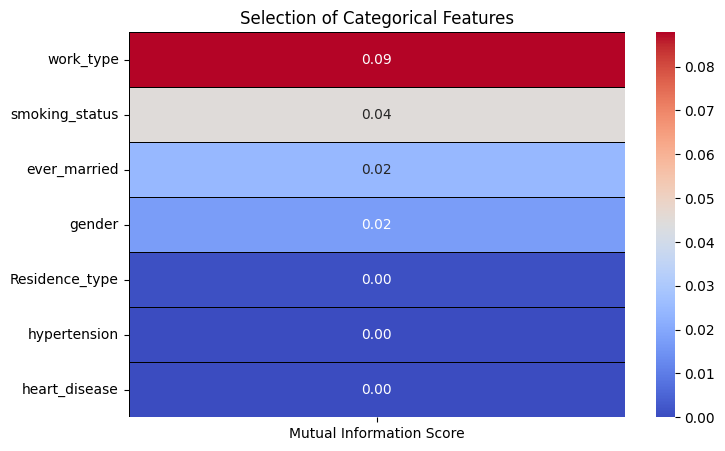

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

features = x_train.loc[:, categorical_features]
target = pd.DataFrame(y_train)

best_features = SelectKBest(score_func=mutual_info_classif, k='all')
fit = best_features.fit(features, target)

featureScores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['Mutual Information Score'])
sns.heatmap(featureScores.sort_values(ascending=False, by='Mutual Information Score'), annot=True, cmap='coolwarm', linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Selection of Categorical Features')

plt.show()

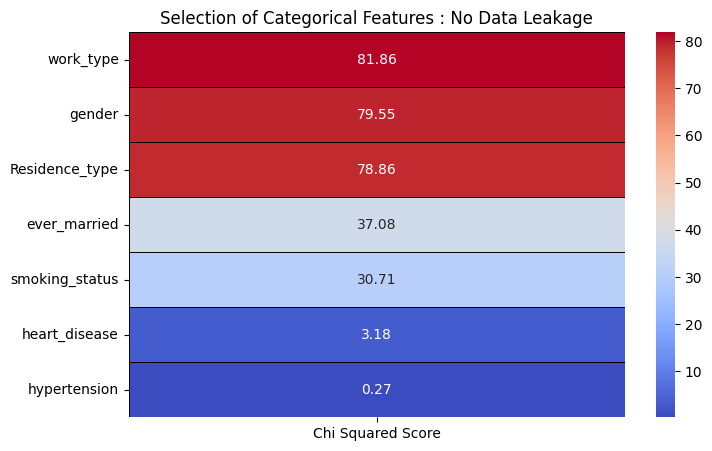

In [29]:
from sklearn.feature_selection import SelectKBest, chi2

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

features = x_train.loc[:, categorical_features]
target = y_train

best_features = SelectKBest(score_func=chi2, k='all')
fit = best_features.fit(features, target)

featureScores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['Chi Squared Score'])
sns.heatmap(featureScores.sort_values(ascending=False, by='Chi Squared Score'), annot=True, cmap='coolwarm', linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Selection of Categorical Features : No Data Leakage')

plt.show()

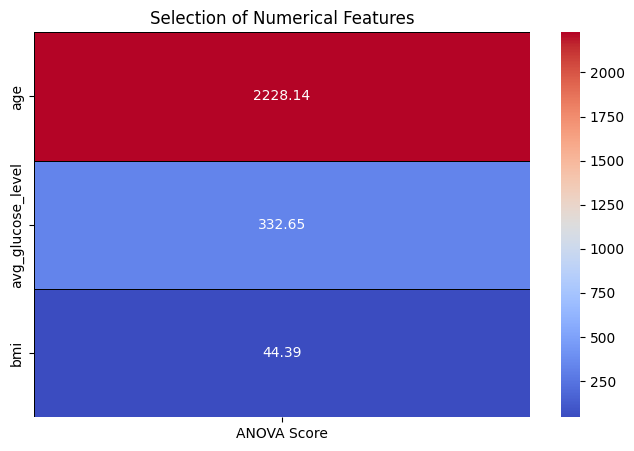

In [30]:
from sklearn.feature_selection import f_classif
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

features = x_train.loc[:, discrete_features]
target = y_train

best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(features, target)

featureScores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['ANOVA Score'])
sns.heatmap(featureScores.sort_values(ascending=False, by='ANOVA Score'), annot=True, cmap='coolwarm', linewidths=0.4, linecolor='black', fmt='.2f')
plt.title('Selection of Numerical Features')

plt.show()

In [72]:
x_train = x_train.drop(columns = ['smoking_status', 'heart_disease', 'hypertension', 'bmi'])
x_test = x_test.drop(columns = ['smoking_status', 'heart_disease', 'hypertension', 'bmi'])

**Data Scaling:**

In [73]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization
# Normalization
x_train['age'] = mms.fit_transform(x_train[['age']])
x_test['age'] = mms.transform(x_test[['age']])
x_train['avg_glucose_level'] = mms.fit_transform(x_train[['avg_glucose_level']])
x_test['avg_glucose_level'] = mms.transform(x_test[['avg_glucose_level']])

# Standardization
x_train['gender'] = ss.fit_transform(x_train[['gender']]); x_test['gender'] = ss.transform(x_test[['gender']])
x_train['ever_married'] = ss.fit_transform(x_train[['ever_married']]); x_test['ever_married'] = ss.transform(x_test[['ever_married']])
x_train['work_type'] = ss.fit_transform(x_train[['work_type']]); x_test['work_type'] = ss.transform(x_test[['work_type']])
x_train['Residence_type'] = ss.fit_transform(x_train[['Residence_type']]); x_test['Residence_type'] = ss.transform(x_test[['Residence_type']])

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import plot_roc_curve
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [75]:
x_train1, x_test1, y_train1, y_test1 = x_train.values, x_test.values, y_train.values, y_test.values

#x_train2, x_test2, y_train2, y_test2 = train_test_split(df2.drop(columns = 'stroke').values, df2['stroke'].values, test_size = 0.15, random_state = 2)

In [76]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def model(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    print("Cross Validation Score:", '{0:.2%}'.format(cross_val_score(classifier, x_train, y_train, cv=cv, scoring='roc_auc').mean()))
    print("ROC_AUC Score:", '{0:.2%}'.format(roc_auc_score(y_test, prediction)))

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, prediction)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def model_evaluation(classifier, x_test, y_test):
    # Confusion Matrix
    cm = confusion_matrix(y_test, classifier.predict(x_test))
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, cmap=colors, fmt='')

    # Classification Report
    print(classification_report(y_test, classifier.predict(x_test)))


Cross Validation Score: 91.55%
ROC_AUC Score: 84.38%


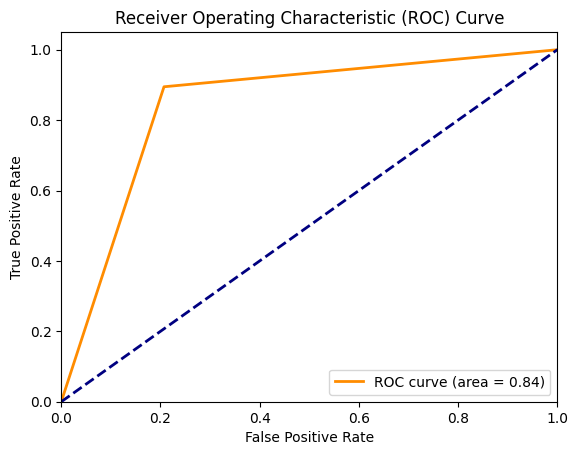

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       367
           1       0.82      0.89      0.85       380

    accuracy                           0.84       747
   macro avg       0.85      0.84      0.84       747
weighted avg       0.85      0.84      0.84       747



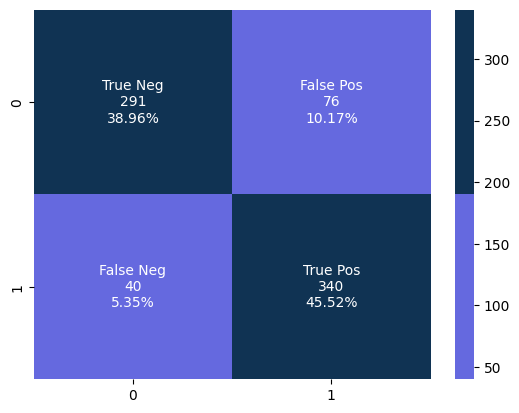

In [77]:
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)
model(classifier_xgb,x_train1,y_train1,x_test1,y_test1)
model_evaluation(classifier_xgb,x_test1,y_test1)

Cross Validation Score: 95.54%
ROC_AUC Score: 88.84%


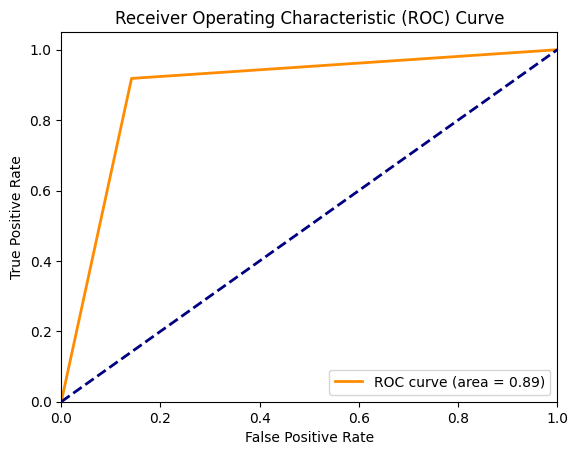

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       367
           1       0.87      0.92      0.89       380

    accuracy                           0.89       747
   macro avg       0.89      0.89      0.89       747
weighted avg       0.89      0.89      0.89       747



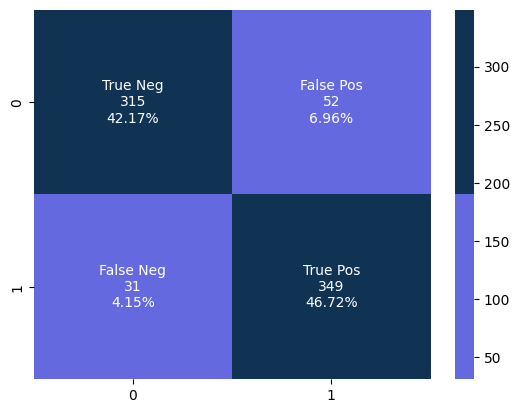

In [78]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model(classifier_rf, x_train1, y_train1, x_test1, y_test1)
model_evaluation(classifier_rf, x_test1, y_test1)

Cross Validation Score: 92.26%
ROC_AUC Score: 85.04%


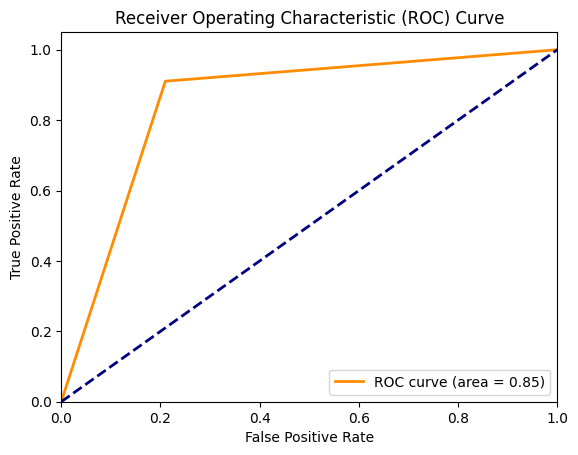

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       367
           1       0.82      0.91      0.86       380

    accuracy                           0.85       747
   macro avg       0.86      0.85      0.85       747
weighted avg       0.86      0.85      0.85       747



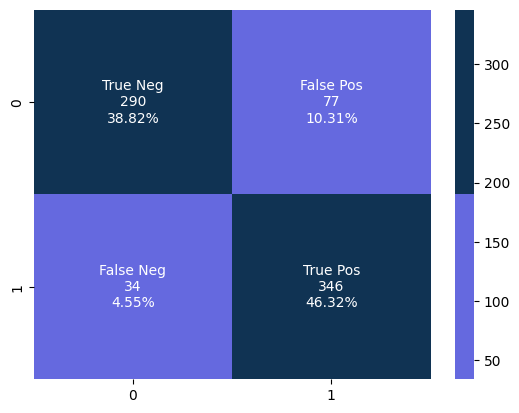

In [79]:
from sklearn.neighbors import KNeighborsClassifier

classifier_knn = KNeighborsClassifier(n_neighbors=5)
model(classifier_knn, x_train1, y_train1, x_test1, y_test1)
model_evaluation(classifier_knn, x_test1, y_test1)

Cross Validation Score: 86.20%
ROC_AUC Score: 85.38%


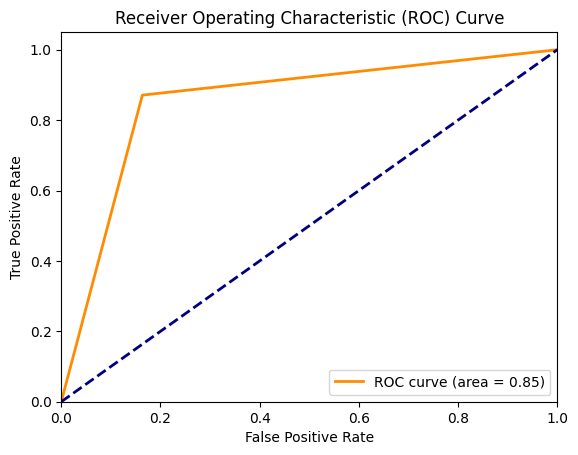

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       367
           1       0.85      0.87      0.86       380

    accuracy                           0.85       747
   macro avg       0.85      0.85      0.85       747
weighted avg       0.85      0.85      0.85       747



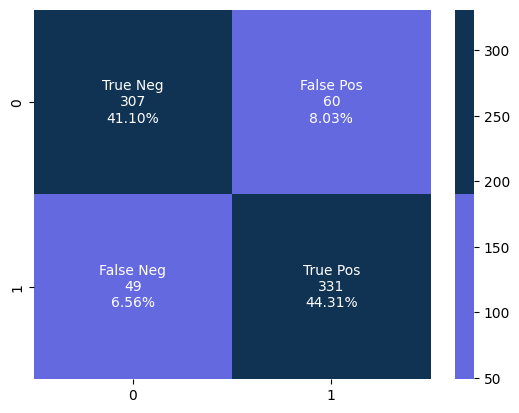

In [80]:
from sklearn.tree import DecisionTreeClassifier

classifier_dt = DecisionTreeClassifier(random_state=42)
model(classifier_dt, x_train1, y_train1, x_test1, y_test1)
model_evaluation(classifier_dt, x_test1, y_test1)
